# Comentarios de Telegram

Partiendo del script de Sergio Molina en su blog para extender los datos de un ETF en base a una regresión lineal del Proxy, he modificado el codigo para que descargue directamente de Tiingo e implementado algunas mejoras.  

Ademas he pensado que sería interesante incluir errores simulados respecto a la regresión en base a la distribución de los errores reales, para tener datos mas cercanos a los de mercado. 

Os paso el notebook por si os interesa.

En rojo datos simulados

In [2]:
from tiingo import TiingoClient
client = TiingoClient({'api_key': '<aqui-tu-key-de-Tiingo>'})

In [3]:
from scipy import stats
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Gradiente: 1.9384513918480994
Intercepto: -9.010008976467667e-05
Coeficiente de correlación: 0.9929189614442955


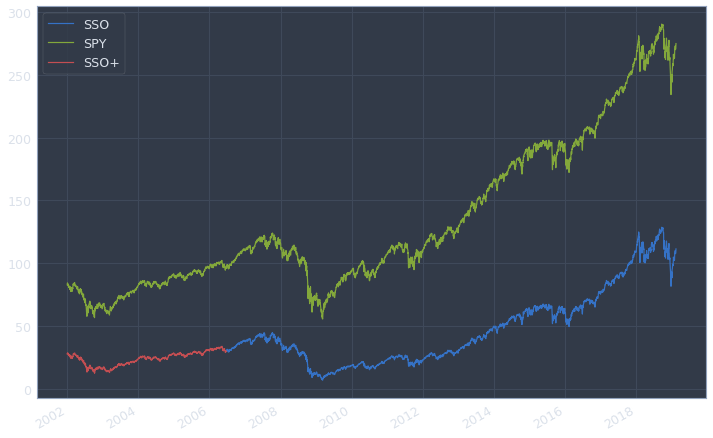

In [7]:
NameETF = 'SSO'  # Ticker del ETF que quieres extender
NameProxy = 'SPY'  # Ticker del CSV que hace de Proxy

data = client.get_dataframe([NameETF, NameProxy],
                            metric_name='adjClose',
                            startDate='2002-01-01')

data[['ETF_returns', 'Proxy_returns']] = data.pct_change().fillna(0)

fechaInicio = data[NameETF].first_valid_index()
fechaFinal = data.last_valid_index()

gradient, intercept, r_value, p_value, std_err = stats.linregress(
    data[['Proxy_returns', 'ETF_returns']].loc[fechaInicio:fechaFinal])

print("Gradiente: {}\nIntercepto: {}\nCoeficiente de correlación: {}".format(
    gradient, intercept, r_value))

data['ETF_returns'][:fechaInicio] = (
    data['Proxy_returns'] * gradient + intercept)[:fechaInicio]
NameExt = NameETF+'+'
data[NameExt] = np.nan
data[NameExt][:fechaInicio] = (data.SSO[fechaInicio] * (1 / (1 + data['ETF_returns'][:fechaInicio].sort_index(ascending=False,
                                                                                                              axis=0))).cumprod())[::-1]

data[[NameETF, NameProxy, NameExt]].plot(figsize=(12, 8));

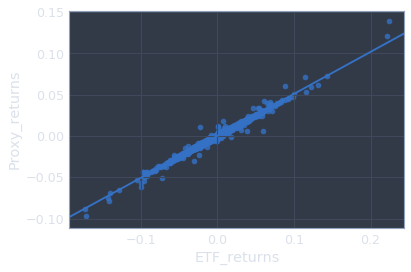

In [8]:
#errores de la regresión lineal con datos de la muestra reales
sns.regplot('ETF_returns','Proxy_returns', data=data[fechaInicio:]);

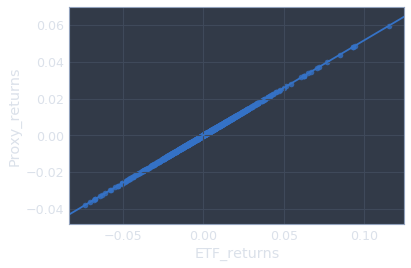

In [9]:
# errores de la regresión lineal con datos simulados, se ajustan perfectamente, 
# no es realista como con los datos de mercado descargados 
sns.regplot('ETF_returns','Proxy_returns', data=data[:fechaInicio]);

Gradiente: 1.9384513918480994
Intercepto: -9.010008976467667e-05
Coeficiente de correlación: 0.9929189614442955


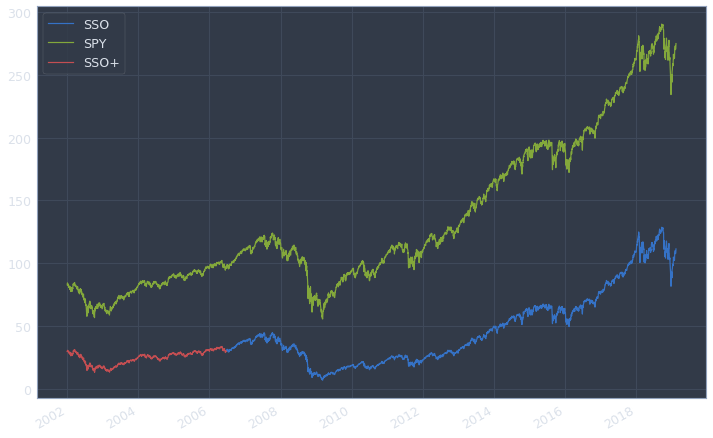

In [10]:
# Añadimos ahora a la simulación los errores
NameETF = 'SSO'  # Ticker del ETF que quieres extender
NameProxy = 'SPY'  # Ticker del CSV que hace de Proxy

data = client.get_dataframe([NameETF, NameProxy],
                            metric_name='adjClose',
                            startDate='2002-01-01')

data[['ETF_returns', 'Proxy_returns']] = data.pct_change().fillna(0)

fechaInicio = data[NameETF].first_valid_index()
fechaFinal = data.last_valid_index()

gradient, intercept, r_value, p_value,
std_err = stats.linregress(
    data[['Proxy_returns', 'ETF_returns']].loc[fechaInicio:fechaFinal])

print("Gradiente: {}\nIntercepto: {}\nCoeficiente de correlación: {}".format(
    gradient, intercept, r_value))

data['errores'] = np.nan
data['errores'][fechaInicio:] = data['ETF_returns'][fechaInicio:] - (
    data['Proxy_returns'] * gradient + intercept)[fechaInicio:]

params = stats.t.fit(data.errores.dropna())
arg = params[:-2]
loc = params[-2]
scale = params[-1]
sim_error = stats.t.rvs(loc=loc, scale=scale, *arg,
                        size=data['ETF_returns'][:fechaInicio].shape[0])

data['ETF_returns'][:fechaInicio] = ((
    data['Proxy_returns'] * gradient + intercept)[:fechaInicio]) + sim_error
NameExt = NameETF+'+'
data[NameExt] = np.nan
data[NameExt][:fechaInicio] = (data.SSO[fechaInicio] * (1 / (1 + data['ETF_returns'][:fechaInicio].sort_index(ascending=False,
                                                                                                              axis=0))).cumprod())[::-1]

data[[NameETF, NameProxy, NameExt]].plot(figsize=(12, 8));

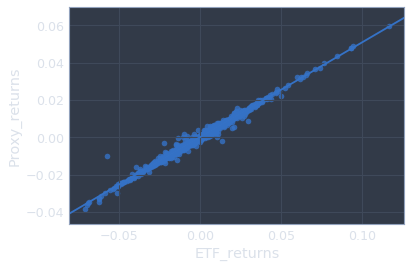

In [11]:
# aunque en la gráfica apenas se aprecía, hay diferencia con el caso anterior
# errores de la regresión lineal con datos simulados, al incluir los errores,
# es mas realista, mas cercano a los valores de partida.
sns.regplot('ETF_returns','Proxy_returns', data=data[:fechaInicio]);